In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare

In [6]:
from scipy import stats
import seaborn as sns
import numpy as np

In [7]:
yellow_2018_06=pd.read_csv('yellow_tripdata_2018-06.csv',encoding='latin1')

In [8]:
taxi_zones=pd.read_csv('taxi_zone_lookup.csv',encoding='latin1')

In [9]:
yellow_tz_2018_06 = yellow_2018_06.merge(taxi_zones,left_on='PULocationID', right_on='LocationID')

In [10]:
#Creation of boroughs column (type Series)
boroughs=yellow_tz_2018_06['Borough']

In [11]:
#Creation of payment_type column (type Series)
payments_type=yellow_tz_2018_06['payment_type']

In [12]:
dict_pay_id={1:'Credit Card', 2:'Cash', 3:'No charge', 4:'Dispute', 5:'Unknown', 6:'Voided trip'}

In [13]:
# Merge the two Series in one dataframe:
df_201806=pd.concat([boroughs,payments_type], axis=1)

In [14]:
# We changed the id of the payments with the real, human readable, name 
# In the dataframe we are using => df_201806 

In [15]:
df_201806['payment_type']=df_201806['payment_type'].apply(lambda x: dict_pay_id[x])

In [16]:
# We need to see in which way are used means for each borough

In [17]:
def count_payments_per_borough(DF):
    d=dict()
    l=len(DF)
    
    for el in DF.iterrows():           #iterating rows through the dataframe
        if el[1][0] not in d.keys():   # if there still no Borough in the dict
            d[el[1][0]]=[[str(el[1][1]),1]]   # add Borough as key, setting the first list with the payment 
                                       # [payment_type, 1]     
        else:
            added=False
            lista=d[el[1][0]]
            for paymenttype_occurrences in lista:
                if paymenttype_occurrences[0] == str(el[1][1]):
                    paymenttype_occurrences[1]+=1
                    added=True
            if added==False:
                d[el[1][0]].append([el[1][1],1])                
           
    return d        

In [18]:
official_df_201806_dict_for_plot=count_payments_per_borough(df_201806)

In [19]:
def plot_dict(d):
    for key in d.keys():
        data_list=d[key]
        
        pay_types, values=zip(*data_list)
        
        fig, ax = plt.subplots(1)
        
        plt.bar(pay_types, values, color="orchid")
        ax.plot(pay_types,values, label=key)
        ax.set_title('%s' %key)
        
        plt.show()   

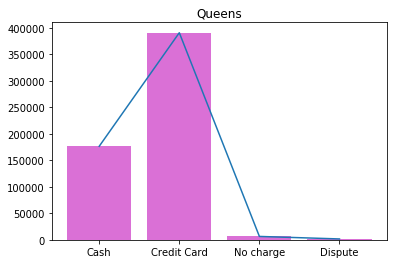

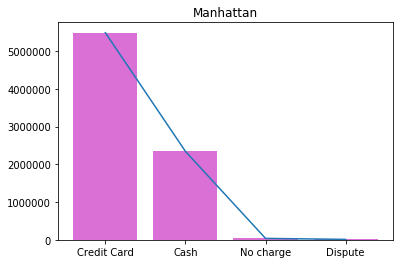

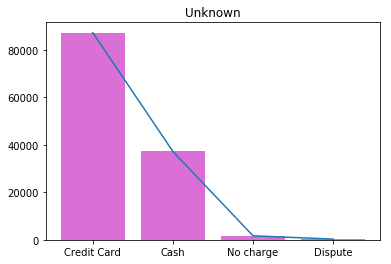

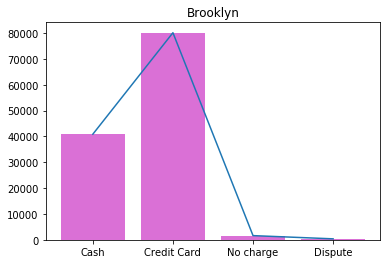

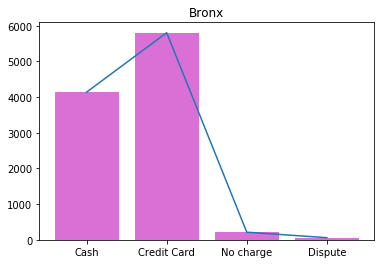

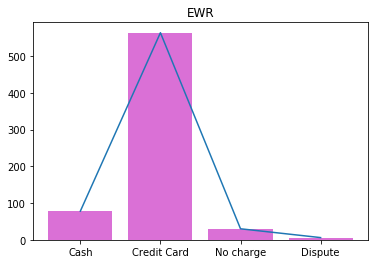

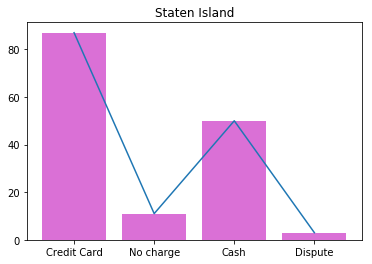

In [20]:
plot_dict(official_df_201806_dict_for_plot)

In [21]:
#######################ChiSquared Test############################

In [22]:
# What we need to do it's to create a new dataframe basing on the dictionary we created and plotted.
# each column (Series) of the dataframe will be represented by borough and all types of payments.
# Chi square test:
# H_0  =  " the payment types are correlated to the borough "
# H_1  =  " the payment types are not correlated to the borough "

In [23]:
official_df_201806_dict_for_plot

{'Queens': [['Cash', 176317],
  ['Credit Card', 390484],
  ['No charge', 6338],
  ['Dispute', 1608]],
 'Manhattan': [['Credit Card', 5486670],
  ['Cash', 2343500],
  ['No charge', 37440],
  ['Dispute', 11199]],
 'Unknown': [['Credit Card', 87144],
  ['Cash', 37159],
  ['No charge', 1681],
  ['Dispute', 287]],
 'Brooklyn': [['Cash', 40856],
  ['Credit Card', 80116],
  ['No charge', 1619],
  ['Dispute', 370]],
 'Bronx': [['Cash', 4138],
  ['Credit Card', 5804],
  ['No charge', 213],
  ['Dispute', 59]],
 'EWR': [['Cash', 78],
  ['Credit Card', 564],
  ['No charge', 30],
  ['Dispute', 6]],
 'Staten Island': [['Credit Card', 87],
  ['No charge', 11],
  ['Cash', 50],
  ['Dispute', 3]]}

In [24]:
def create_df_b_pt(d):
    chi = {}
    #chi['Borough']=d.keys()
    #print(chi['Borough'])
    
    for e in d:
        for item in d[e]:
            if item[0] not in chi:
                chi[item[0]]=[item[1]]
            else:
                chi[item[0]].append(item[1])
    
    df=pd.DataFrame.from_dict(chi)
    df.loc[:,'Borough'] = pd.Series(list(d.keys()))
    return df   

In [26]:
#del chi_df

In [27]:
chi_df = create_df_b_pt(official_df_201806_dict_for_plot)

In [28]:
chi_df

,Cash,Credit Card,No charge,Dispute,Borough
0,176317,390484,6338,1608,Queens
1,2343500,5486670,37440,11199,Manhattan
2,37159,87144,1681,287,Unknown
3,40856,80116,1619,370,Brooklyn
4,4138,5804,213,59,Bronx
5,78,564,30,6,EWR
6,50,87,11,3,Staten Island


In [29]:
def add_total_in_df(df):
    #first, deleting borough for make the sum without problem on string+int
    res_df= chi_df
    res_df=res_df.drop('Borough', 1)
    tot_columns=[]   #total per rows
    i=0
    r_df, c_df = res_df.shape
    while i<r_df:
        s = sum(res_df.iloc[i])
        i+=1
        tot_columns.append(s)
        
    i=0
    tot_rows=[] 
    s=0
    
    for pt in (res_df.columns).tolist():
        for element in res_df[str(pt)]:
            s += element
        tot_rows.append(s)
        s=0
    
    somma=sum(tot_rows)
    res_df.loc[7] = np.array(tot_rows)
    
    tot_columns.append(somma)
    res_df['Total'] = pd.Series(tot_columns)
    return res_df

In [30]:
aux_chi = add_total_in_df(chi_df)

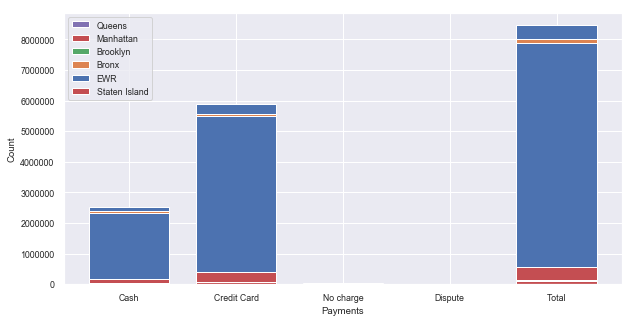

In [32]:
#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=0.8)
categories = ['Cash', 'Credit Card', 'No charge', 'Dispute', 'Total']
p0 = plt.bar( categories, queens_count, 0.75, color='r')
p1 = plt.bar( categories, manhattan_count, 0.75, bottom = queens_count)
p3 = plt.bar( categories, brooklyn_count, 0.75, bottom = manhattan_count)
p4 = plt.bar( categories, bronx_count, 0.75, bottom = brooklyn_count)
p5 = plt.bar( categories, ewr_count, 0.75, bottom = bronx_count)
p6 = plt.bar( categories, si_count, 0.75, bottom = ewr_count)
plt.legend((p6[0], p5[0], p4[0], p3[0], p1[0], p0[0]), ('Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'EWR','Staten Island'))
plt.xlabel('Payments')
plt.ylabel('Count')
plt.show()

In [34]:
aux_chi

,Cash,Credit Card,No charge,Dispute,Total
0,176317,390484,6338,1608,574747
1,2343500,5486670,37440,11199,7878809
2,37159,87144,1681,287,126271
3,40856,80116,1619,370,122961
4,4138,5804,213,59,10214
5,78,564,30,6,678
6,50,87,11,3,151
7,2602098,6050869,47332,13532,8713831


In [41]:
col_sums

array([2602098, 6050869,   47332,   13532], dtype=int64)

Percentage of frequency for each row: why?
We need to know the relations between the borough and the payment types.
We computed the percentage of trips for each borough.

Knowing this, we took all the observed rows for each borough, making the Chi-Square Test with the expected 
number of trips with an exact payment type. 

We got the statistic and the pvalue.

In [67]:
def percentage(dataf):
    array = []
    freq=list(dataf['Total'])
    tot = dataf.loc[7]['Total'] #Total number of paid trips for each borough
    i=0
    for el in freq:
        array.append(el*100/tot)
    return array

In [56]:
#Assigns the frequency values
queens_obs = np.array(aux_chi.iloc[0][0:4].values)
manhattan_obs = np.array(aux_chi.iloc[1][0:4].values)
brooklyn_obs = np.array(aux_chi.iloc[3][0:4].values)
bronx_obs = np.array(aux_chi.iloc[4][0:4].values)
ewr_obs = np.array(aux_chi.iloc[5][0:4].values)
si_obs = np.array(aux_chi.iloc[6][0:4].values)

In [57]:
arr = percentage(aux_chi)

In [40]:
col_sums = aux_chi.iloc[7,0:4].values

In [58]:
queens_exp_freq = [arr[0]*el for el in col_sums]
manhattan_exp_freq = [arr[1]*el for el in col_sums]
brooklyn_exp_freq = [arr[3]*el for el in col_sums]
bronx_exp_freq = [arr[4]*el for el in col_sums]
ewr_exp_freq = [arr[5]*el for el in col_sums]
si_exp_freq = [arr[6]*el for el in col_sums]

In [60]:
stats.chisquare(queens_obs, queens_exp_freq)

Power_divergenceResult(statistic=56330995.47756882, pvalue=0.0)

In [61]:
stats.chisquare(manhattan_obs, manhattan_exp_freq)


Power_divergenceResult(statistic=772202078.481929, pvalue=0.0)

In [62]:
stats.chisquare(brooklyn_obs, brooklyn_exp_freq)

Power_divergenceResult(statistic=12051430.745529164, pvalue=0.0)

In [63]:
stats.chisquare(bronx_obs, bronx_exp_freq)

Power_divergenceResult(statistic=1001086.0070785915, pvalue=0.0)

In [64]:
stats.chisquare(ewr_obs, ewr_exp_freq)

Power_divergenceResult(statistic=66453.84269550799, pvalue=0.0)

In [66]:
stats.chisquare(si_obs, si_exp_freq)

Power_divergenceResult(statistic=14801.135339172066, pvalue=0.0)

We seen that all the pvalues are equal to 0.0, thus there is no correlation between the payment method and the borough. 

In [68]:
del yellow_2018_06
del taxi_zones
del yellow_tz_2018_06
del df_201806
del official_df_201806_dict_for_plot